# [Dataset name]

:::{eval-rst}
:opticon:`tag`
:badge:`[Environment],badge-primary`
:badge:`Exploration,badge-secondary`
:::

## Context
### Purpose
*Describe the purpose of the use case.*

### Dataset description
*Describe the main features of the dataset/sensor e.g. variables.*

### Highlights
*Provide 3-5 bullet points that convey the use case’s core procedures. Each bullet point must have a maximum of 85 characters, including spaces.*
* Highlight 1
* Highlight 2

### Contributions

#### Notebook
Author (role), Affiliation, GitHub alias

#### Dataset originator/creator
Institution/Community/Individual (affiliation)

#### Dataset authors
Institution/Community/Individual (affiliation)

#### Dataset documentation
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "replace by the `topic` entry linked to the publication(s) in the `_bibliography/references.bib` file"
```

:::{note}
*Optional: add credits or acknowledgements to data providers or authors of code snippets*
:::

## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation e.g. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the notebooks. Don't remove them.*

In [1]:
#import os
#import warnings
#warnings.filterwarnings(action='ignore')

## Example multitemporal land use (london)
from pystac_client import Client
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.stac import stac_load
import rasterio
from pystac.extensions.item_assets import ItemAssetsExtension
import numpy as np
from matplotlib.colors import ListedColormap
import pandas as pd

## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Change `<replace-by-notebook-filename>` with your notebook identifier.*

In [3]:
notebook_folder = './landcover-exploration-nlcd'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

NameError: name 'os' is not defined

## Load data
*Load full dataset from original or mirror sources. If the license of the dataset permits, we suggest creating sample data (preprocessed) for the notebook stored in a data repository e.g. Zenodo.*

In [4]:
km2deg = 1.0 / 111
x, y = (-0.118092, 51.509865)  # Center point of a query
r = 100 * km2deg
bbox = (x - r, y - r, x + r, y + r)

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

query = catalog.search(
    collections=["io-lulc-9-class"],
    limit=100,
    bbox=bbox
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 10 datasets


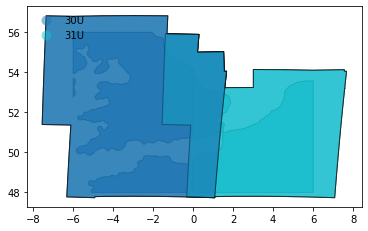

In [5]:
# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.get_all_items_as_dict()

gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

fig = gdf.plot(
    "io:tile_id",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)

plt.show()

In [6]:
# Load with bounding box
r = 40 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)
crs = "epsg:3857"


#load at 10m resolution
lon10 = stac_load(
    items,
    bands=("data"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    groupby="start_datetime",
    bbox=small_bbox,
)

#load at 100m resolution
lon100 = stac_load(
    items,
    bands=("data"),
    crs=crs,
    resolution=100,
    chunks={},  # <-- use Dask
    groupby="start_datetime",
    bbox=small_bbox,
)

#load at 1000m resolution
lon1000 = stac_load(
    items,
    bands=("data"),
    crs=crs,
    resolution=1000,
    chunks={},  # <-- use Dask
    groupby="start_datetime",
    bbox=small_bbox,
)

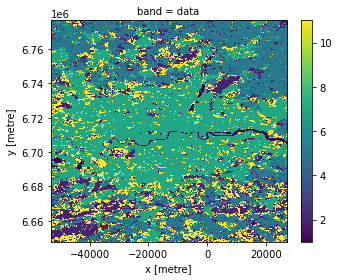

/home/james/anaconda3/envs/eds-lc/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


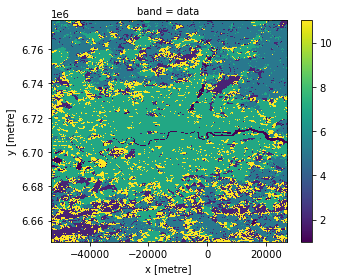

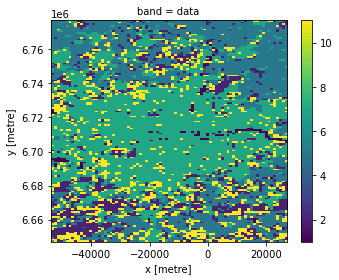

In [7]:
merged = lon10.compute()

_ = (
    merged.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
    )
)
plt.show()

merged = lon100.compute()

_ = (
    merged.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
    )
)
plt.show()


merged = lon1000.compute()

_ = (
    merged.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
    )
)
plt.show()

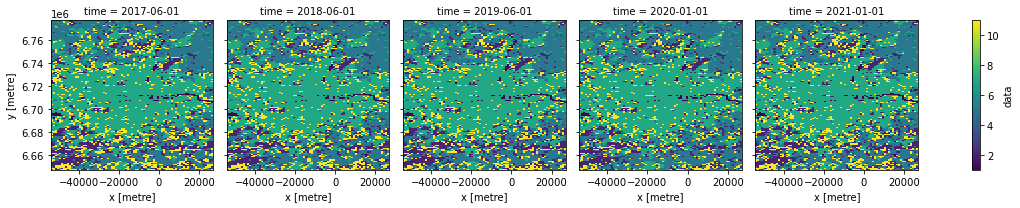

In [8]:
g = merged['data'].plot(col="time")
plt.show()

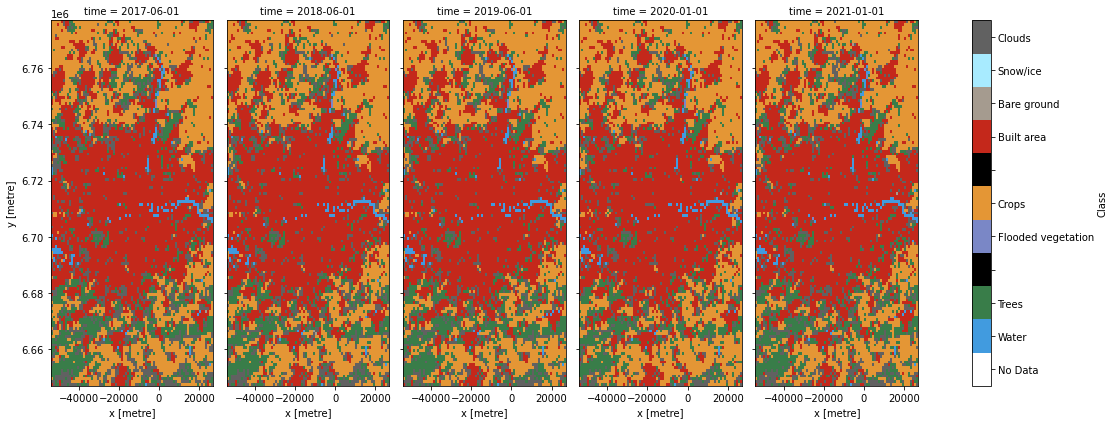

In [9]:
collection = catalog.get_collection("io-lulc-9-class")
ia = ItemAssetsExtension.ext(collection)

x = ia.item_assets["data"]
class_names = {x["summary"]: x["values"][0] for x in x.properties["file:values"]}
values_to_classes = {v: k for k, v in class_names.items()}
class_count = len(class_names)

with rasterio.open(items[0].assets["data"].href) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(max(class_names.values()))
    ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

vmin = 0
vmax = max(class_names.values())

p = merged.data.plot(
    col="time",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    figsize=(16, 6),
)
ticks = np.linspace(0.5, 10.5, 11)
labels = [values_to_classes.get(i, "") for i in range(cmap.N)]
p.cbar.set_ticks(ticks, labels=labels)
p.cbar.set_label("Class")

## Visualisation
*Create a visual narrative of the dataset! We suggest exploring libraries suited for interactive plotting e.g. Holoviews, Panel, Bokeh.*

## Summary
*Provide 3-5 bullet points summarising the main aspects of the dataset and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information
**Dataset**: Type here details of dataset(s) version.

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [10]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-07-18
